In [ ]:
%load_ext autoreload
%autoreload 2

# general
import numpy as np
import pandas as pd
from spectral import open_image, envi
from sklearn.preprocessing import MinMaxScaler
import re

# spatial
import xarray as xa
import rasterio
import pyproj
import rioxarray
import xesmf as xe

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import joblib


from sklearn.metrics import r2_score
from scipy.stats import ks_2samp
from sklearn.decomposition import PCA
from statsmodels.multivariate.manova import MANOVA

# custom
from reflectance import spectrum_utils, file_ops, optimisation_pipeline, plotting, ml_utils

In [ ]:
corr_fp = file_ops.DATA_DIR_FP / "prism_images" / "prism_kbay_corr_ss.img"
corr_fp_hdr = file_ops.DATA_DIR_FP / "prism_images" / "prism_kbay_corr_ss.img.hdr"
mask_fp = file_ops.DATA_DIR_FP / "prism_images" / "prism_kbay_mask_ss.img"
mask_fp_hdr = file_ops.DATA_DIR_FP / "prism_images" / "prism_kbay_mask_ss.img.hdr"

hs_mask_metadata = open_image(mask_fp_hdr)
hs_corrected_metadata = open_image(corr_fp_hdr)
print("masked:", hs_mask_metadata)
print("corrected:", hs_corrected_metadata)
hs_corrected_data = open_image(corr_fp_hdr).load()

masked: 	Data Source:   '/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/coralreflections/data/prism_images/prism_kbay_mask_ss.img'
	# Rows:           1045
	# Samples:         863
	# Bands:             1
	Interleave:        BSQ
	Quantization:   8 bits
	Data format:     uint8
corrected: 	Data Source:   '/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/coralreflections/data/prism_images/prism_kbay_corr_ss.img'
	# Rows:           1045
	# Samples:         863
	# Bands:           246
	Interleave:        BSQ
	Quantization:  32 bits
	Data format:   float32


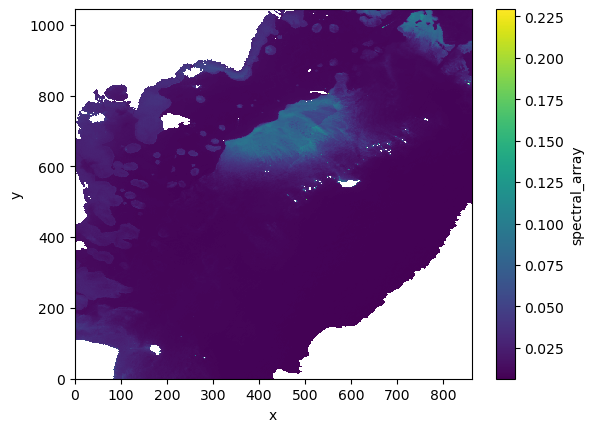

In [ ]:
from pyproj import Transformer

def envi_to_xarray_with_latlon(envi_fp, band_vals: list[float]=None):
    # Open the ENVI file using rasterio
    with rasterio.open(envi_fp) as src:
        data = src.read()
        transform = src.transform
        height, width = src.shape

        # generate UTM coordinates from pixel indices using the affine transform
        x_coords, y_coords = np.meshgrid(np.arange(width), np.arange(height))
        x_coords, y_coords = rasterio.transform.xy(transform, y_coords, x_coords)

        # Convert the UTM coordinates to numpy arrays
        x_coords = np.array(x_coords)
        y_coords = np.array(y_coords)

        # Convert UTM to lat/lon using pyproj or rasterio's CRS info
        transformer = Transformer.from_crs(src.crs, "EPSG:4326", always_xy=True)
        lon_coords, lat_coords = transformer.transform(x_coords, y_coords)

        # Reshape lat and lon arrays to match the image dimensions
        lat_coords = np.reshape(lat_coords, (height, width))
        lon_coords = np.reshape(lon_coords, (height, width))

        # Create the xarray Dataset with lat/lon as coordinates
        dataset = xa.DataArray(
            data=data,  # The raster data
            dims=("band", "y", "x"),  # Dimensions of the data (e.g., bands, rows, cols)
            coords={
                "lat": (["y", "x"], lat_coords),  # Latitude coordinates (reshaped)
                "lon": (["y", "x"], lon_coords),  # Longitude coordinates (reshaped)
                "band": band_vals if band_vals else np.arange(1, data.shape[0] + 1),  # Band indices
            },
            attrs=src.meta  # Include the ENVI metadata
        )
        
    return dataset

spatial_xy_xa = envi_to_xarray_with_latlon(corr_fp)
mask_xa = envi_to_xarray_with_latlon(mask_fp)
# broadcast mask_xa to have same number of bands as scene_xa
mask_xa = mask_xa.broadcast_like(spatial_xy_xa)
mask_xa.values = np.broadcast_to(mask_xa.values[0], mask_xa.shape)
masked_scene_xa = spatial_xy_xa.where(mask_xa == 1, np.nan)
masked_scene_xa.name = "spectral_array"
# assign band values actual wavelength values
masked_scene_xa.coords["band"] = hs_corrected_metadata.bands.centers

# visualise data
mean_scene_xa = masked_scene_xa.median(dim="band", skipna=True)
mean_scene_xa.plot.imshow();

In [ ]:
# matching spectra
validation_spectra_fp = file_ops.DATA_DIR_FP / "CORAL_validation_spectra.csv"
validation_data = pd.read_csv(file_ops.DATA_DIR_FP / "CORAL_validation_data.csv")
validation_spectra = pd.read_csv(validation_spectra_fp)
validation_spectra.columns = validation_spectra.columns.astype(float)
kbay_indices = validation_data[validation_data.Locale == "Kaneohe Bay"].index
# select kbay spectra
kbay_validation_spectra = validation_spectra.iloc[kbay_indices]
kbay_validation_spectra.head()

,350.718103,353.548360,356.378673,359.209042,362.039467,364.869949,367.700487,370.531081,373.361731,376.192438,...,1020.218215,1023.061744,1025.905330,1028.748971,1031.592670,1034.436424,1037.280234,1040.124101,1042.968024,1045.812003
1151,-0.0936,-0.0753,0.0055,0.0092,0.0261,0.0194,0.0168,0.0170,0.0169,0.0213,...,0.0076,0.0070,0.0067,0.0071,0.0076,0.0061,0.0072,0.0068,0.0070,0.0072
1152,-0.1003,-0.0732,0.0104,0.0123,0.0251,0.0189,0.0178,0.0199,0.0180,0.0227,...,0.0073,0.0077,0.0072,0.0069,0.0069,0.0075,0.0073,0.0078,0.0077,0.0073
1153,-0.0942,-0.0749,0.0012,0.0124,0.0233,0.0247,0.0194,0.0187,0.0168,0.0208,...,0.0071,0.0069,0.0071,0.0072,0.0072,0.0072,0.0067,0.0068,0.0069,0.0068
1154,-0.0933,-0.0721,0.0007,0.0100,0.0232,0.0218,0.0167,0.0204,0.0158,0.0201,...,0.0068,0.0066,0.0064,0.0065,0.0064,0.0069,0.0070,0.0071,0.0060,0.0063
1155,-0.1004,-0.0798,-0.0035,0.0052,0.0208,0.0164,0.0109,0.0154,0.0125,0.0159,...,0.0073,0.0069,0.0070,0.0075,0.0076,0.0078,0.0078,0.0078,0.0084,0.0075


In [ ]:
kbay_spectra = ml_utils.spectral_xa_to_processed_spectral_df(masked_scene_xa, sensor_range = [kbay_validation_spectra.columns.min(), kbay_validation_spectra.columns.max()+10]) # discrepancy in wavelength values much!!
kbay_spectra_no_nans = kbay_spectra.dropna(inplace=False)
kbay_spectra_no_nans.head()

,350.718109,353.548370,356.378662,359.209045,362.039459,364.869934,367.700500,370.531067,373.361725,376.192444,...,1020.218201,1023.061768,1025.905273,1028.749023,1031.592651,1034.436401,1037.280273,1040.124146,1042.968018,1045.812012
84,-0.226065,-0.173343,0.029054,0.026362,0.048827,0.039588,0.029481,0.023329,0.017586,0.022286,...,0.003392,0.002484,0.004786,0.006878,0.006311,0.009455,0.009783,0.012087,0.013919,0.016255
85,-0.185080,-0.145685,0.031734,0.042032,0.056400,0.049959,0.036195,0.036955,0.023494,0.027282,...,-0.004237,-0.004126,-0.003085,-0.002034,0.000286,0.002187,0.001824,0.002732,0.004041,0.006909
86,-0.185541,-0.129247,0.039026,0.036056,0.053762,0.046651,0.035294,0.030869,0.022162,0.028531,...,-0.000491,0.001376,0.001426,0.003975,0.003139,0.004987,0.006605,0.008619,0.009294,0.010524
87,-0.177682,-0.122697,0.040667,0.046347,0.061807,0.045808,0.036235,0.036893,0.023296,0.029488,...,0.000901,0.001693,0.002987,0.003684,0.004522,0.004675,0.006394,0.006645,0.008309,0.011872
88,-0.177682,-0.122697,0.040667,0.046347,0.061807,0.045808,0.036235,0.036893,0.023296,0.029488,...,0.000901,0.001693,0.002987,0.003684,0.004522,0.004675,0.006394,0.006645,0.008309,0.011872


In [ ]:
import pandas as pd
import numpy as np
from scipy.spatial import KDTree

# Build KDTree for kbay_spectra (the dataset to be searched for the closest spectra)
tree = KDTree(kbay_spectra_no_nans.values)

# Query the KDTree to find the nearest neighbor in kbay_spectra for each spectrum in kbay_validation_spectra
# This returns both the distance and the index of the closest point in kbay_spectra
distances, indices = tree.query(kbay_validation_spectra.values, k=1)  # k=1 finds the single closest match

In [ ]:
kbay_spectra_no_nans

,350.718109,353.548370,356.378662,359.209045,362.039459,364.869934,367.700500,370.531067,373.361725,376.192444,...,1020.218201,1023.061768,1025.905273,1028.749023,1031.592651,1034.436401,1037.280273,1040.124146,1042.968018,1045.812012
84,-0.226065,-0.173343,0.029054,0.026362,0.048827,0.039588,0.029481,0.023329,0.017586,0.022286,...,0.003392,0.002484,0.004786,0.006878,0.006311,0.009455,0.009783,0.012087,0.013919,0.016255
85,-0.185080,-0.145685,0.031734,0.042032,0.056400,0.049959,0.036195,0.036955,0.023494,0.027282,...,-0.004237,-0.004126,-0.003085,-0.002034,0.000286,0.002187,0.001824,0.002732,0.004041,0.006909
86,-0.185541,-0.129247,0.039026,0.036056,0.053762,0.046651,0.035294,0.030869,0.022162,0.028531,...,-0.000491,0.001376,0.001426,0.003975,0.003139,0.004987,0.006605,0.008619,0.009294,0.010524
87,-0.177682,-0.122697,0.040667,0.046347,0.061807,0.045808,0.036235,0.036893,0.023296,0.029488,...,0.000901,0.001693,0.002987,0.003684,0.004522,0.004675,0.006394,0.006645,0.008309,0.011872
88,-0.177682,-0.122697,0.040667,0.046347,0.061807,0.045808,0.036235,0.036893,0.023296,0.029488,...,0.000901,0.001693,0.002987,0.003684,0.004522,0.004675,0.006394,0.006645,0.008309,0.011872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
901830,-0.196233,-0.136284,0.036979,0.041104,0.075436,0.070244,0.063448,0.066963,0.056230,0.063454,...,-0.000908,-0.000746,-0.000518,-0.001035,0.000813,0.000199,0.001249,0.000073,0.000067,-0.000180
901831,-0.205698,-0.138908,0.051432,0.054575,0.076643,0.072342,0.064835,0.065242,0.059031,0.063625,...,-0.001031,-0.000384,-0.001158,-0.000316,-0.000444,0.001594,0.000629,0.000618,0.002423,0.001180
901832,-0.211574,-0.128616,0.041478,0.048422,0.078161,0.067005,0.062965,0.066848,0.058741,0.064208,...,-0.000047,-0.001585,-0.000621,-0.000632,0.000291,-0.000907,0.000723,-0.000003,0.002360,0.001193
901833,-0.196651,-0.128256,0.052801,0.055943,0.079267,0.068772,0.061382,0.069132,0.056517,0.069051,...,-0.001095,0.000027,-0.000986,-0.002144,-0.000336,-0.000517,0.000158,0.000782,-0.000176,0.001317


In [ ]:
# how many of "indices" are in kbay_spectra_no_nans?
len(kbay_spectra_no_nans.iloc[indices].dropna())

421

In [ ]:
pd.DataFrame(kbay_spectra.index.isin(indices).astype(float), columns=["site"])

,site
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
901830,0.0
901831,0.0
901832,0.0
901833,0.0


In [ ]:
site_df = pd.DataFrame(kbay_spectra.index.isin(indices).astype(float), columns=["site"])

site_array = xa.DataArray(
    data=site_df.values.reshape(masked_scene_xa.shape[1], masked_scene_xa.shape[2]), 
    coords={"lat": masked_scene_xa.coords["lat"], "lon": masked_scene_xa.coords["lon"]}, 
    dims=("y", "x"), 
    name="site"
)
site_array.rio.write_crs(masked_scene_xa.rio.crs, inplace=True)

site_array = site_array.assign_coords(
    x=np.arange(masked_scene_xa.sizes['x']),
    y=np.arange(masked_scene_xa.sizes['y'])
)


# merge with masked_scene_xa
scene_site_xa = xa.merge([site_array, masked_scene_xa])
scene_site_xa.rio.write_crs(masked_scene_xa.rio.crs, inplace=True)

scene_site_xa = scene_site_xa.assign_coords(
    x=np.arange(scene_site_xa.sizes['x']),
    y=np.arange(scene_site_xa.sizes['y'])
)

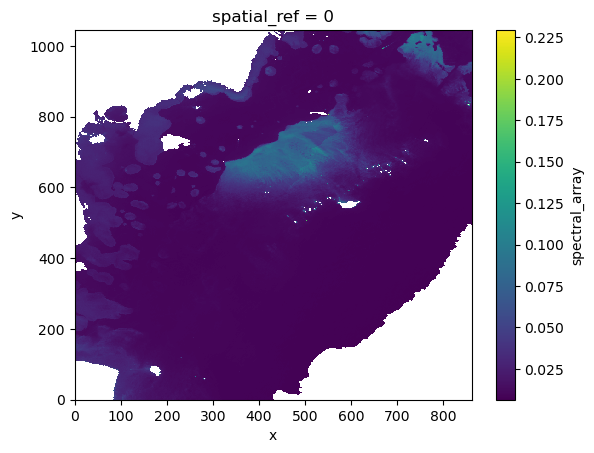

In [ ]:
scene_site_xa.spectral_array.median(dim="band", skipna=True).plot.imshow();

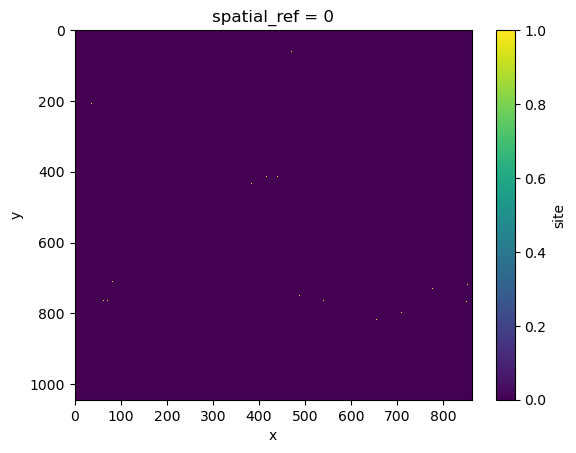

In [ ]:
scene_site_xa.site.plot.imshow();
plt.gca().invert_yaxis()
# plot as scatter the validation locations (from X and Y columns)

In [ ]:
print("retrieved spectra:", len(indices))
print("og spectra:", len(kbay_validation_spectra))

retrieved spectra: 421
og spectra: 421


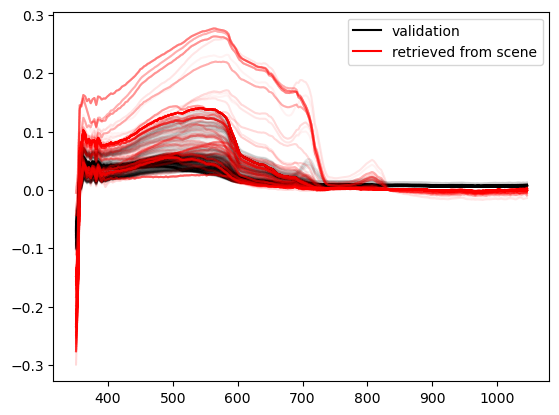

In [ ]:
# plot the retrieved spectra and the validation spectra
plt.plot(kbay_validation_spectra.T, c="k", alpha=0.05);
# retrieved spectra 
retrieved_spectra = kbay_spectra.iloc[indices]
plt.plot(retrieved_spectra.T, c="r", alpha=0.05);

plt.plot([], c="k", label="validation")
plt.plot([], c="r", label="retrieved from scene")
plt.legend();

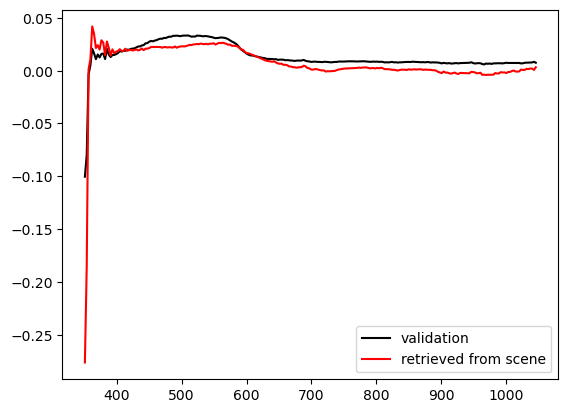

In [ ]:
i = 4
plt.plot(kbay_validation_spectra.iloc[i], c="k", label="validation")
plt.plot(retrieved_spectra.iloc[i], c="r", label="retrieved from scene")
plt.legend()

In [ ]:
test_site_xa = ml_utils.regrid_with_xesmf(site_array)

In [ ]:
test_scene_xa = ml_utils.regrid_with_xesmf(masked_scene_xa)

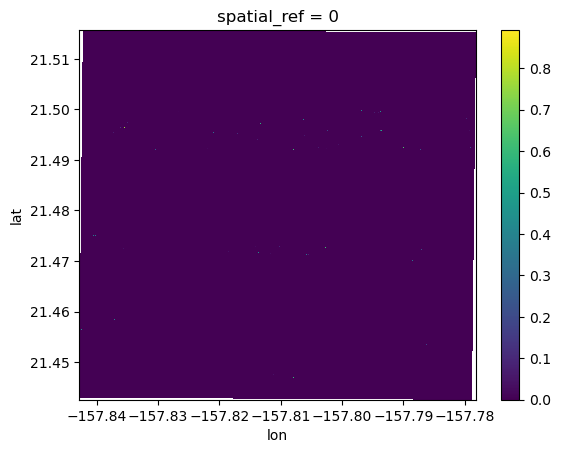

In [ ]:
test_site_xa.plot.imshow();

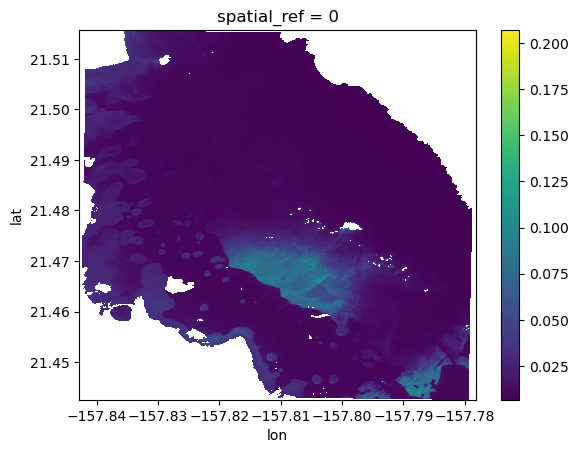

In [ ]:
test_scene_xa.median(dim="band", skipna=True).plot.imshow();

In [ ]:
test_site_xa.name = "site"
test_scene_xa.name = "spectral_array"

In [ ]:
# merge
test_scene_site_xa = xa.merge([test_site_xa, test_scene_xa])

In [ ]:
(~np.isnan(test_scene_site_xa.site.values)).shape

(1045, 863)

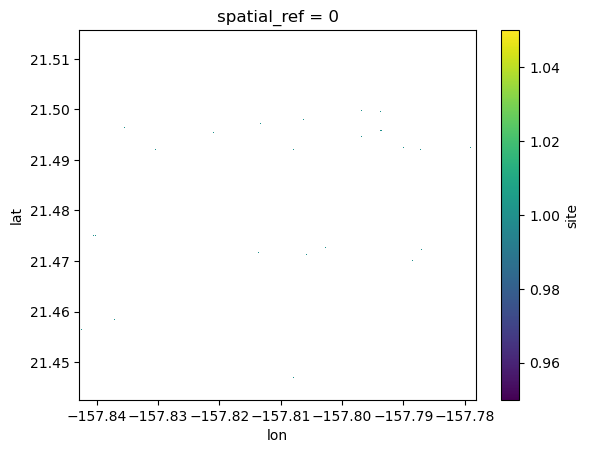

In [ ]:
# cast all values below 0.1 to nan, all above to 1
test_scene_site_xa.site.values[test_scene_site_xa.site.values < 0.2] = np.nan
test_scene_site_xa.site.values[test_scene_site_xa.site.values >= 0.2] = 1
test_scene_site_xa.site.plot.imshow();

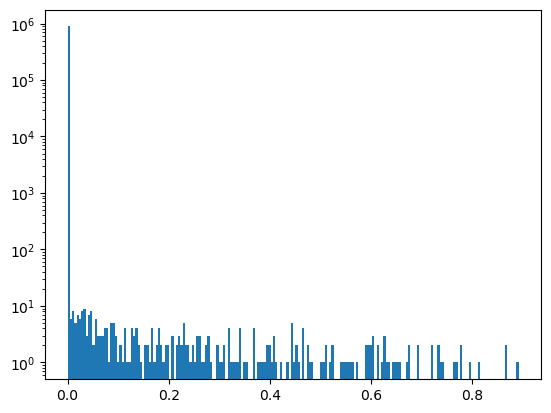

In [ ]:
plt.hist(test_scene_site_xa.site.values.flatten(), bins=200);
plt.yscale("log")

In [ ]:
np.nansum(test_scene_site_xa.site.values.flatten() != 0)

15990

In [ ]:
# np.nansum(test_scene_site_xa.site.values)
np.nansum(test_site_xa.values)

55.0

In [ ]:
test_scene_site_xa.spectral_array.values.shape

(246, 1045, 863)

In [ ]:
test_scene_site_xa

<xarray.Dataset> Size: 895MB
Dimensions:         (lat: 1045, lon: 863, band: 246)
Coordinates:
  * lat             (lat) float64 8kB 21.44 21.44 21.44 ... 21.52 21.52 21.52
  * lon             (lon) float64 7kB -157.8 -157.8 -157.8 ... -157.8 -157.8
    spatial_ref     int64 8B 0
  * band            (band) float64 2kB 350.7 353.5 356.4 ... 1.043e+03 1.046e+03
Data variables:
    site            (lat, lon) float64 7MB nan nan nan nan ... nan nan nan nan
    spectral_array  (band, lat, lon) float32 887MB nan nan nan ... nan nan nan
Attributes:
    _FillValue:  nan

In [ ]:
# create a grid of latitude and longitude values
lat = np.linspace(test_scene_site_xa.lat.min(), test_scene_site_xa.lat.max(), test_scene_site_xa.sizes["lat"])
lon = np.linspace(test_scene_site_xa.lon.min(), test_scene_site_xa.lon.max(), test_scene_site_xa.sizes["lon"])
lat, lon = np.meshgrid(lat, lon)
lon.shape

(863, 1045)

In [ ]:
# site_x, site_y = np.where(~np.isnan(test_scene_site_xa.site.values))
# retrieve all spectra at these locations
test_scene_site_xa.spectral_array.values[:, site_x, site_y].shape

(246, 148)

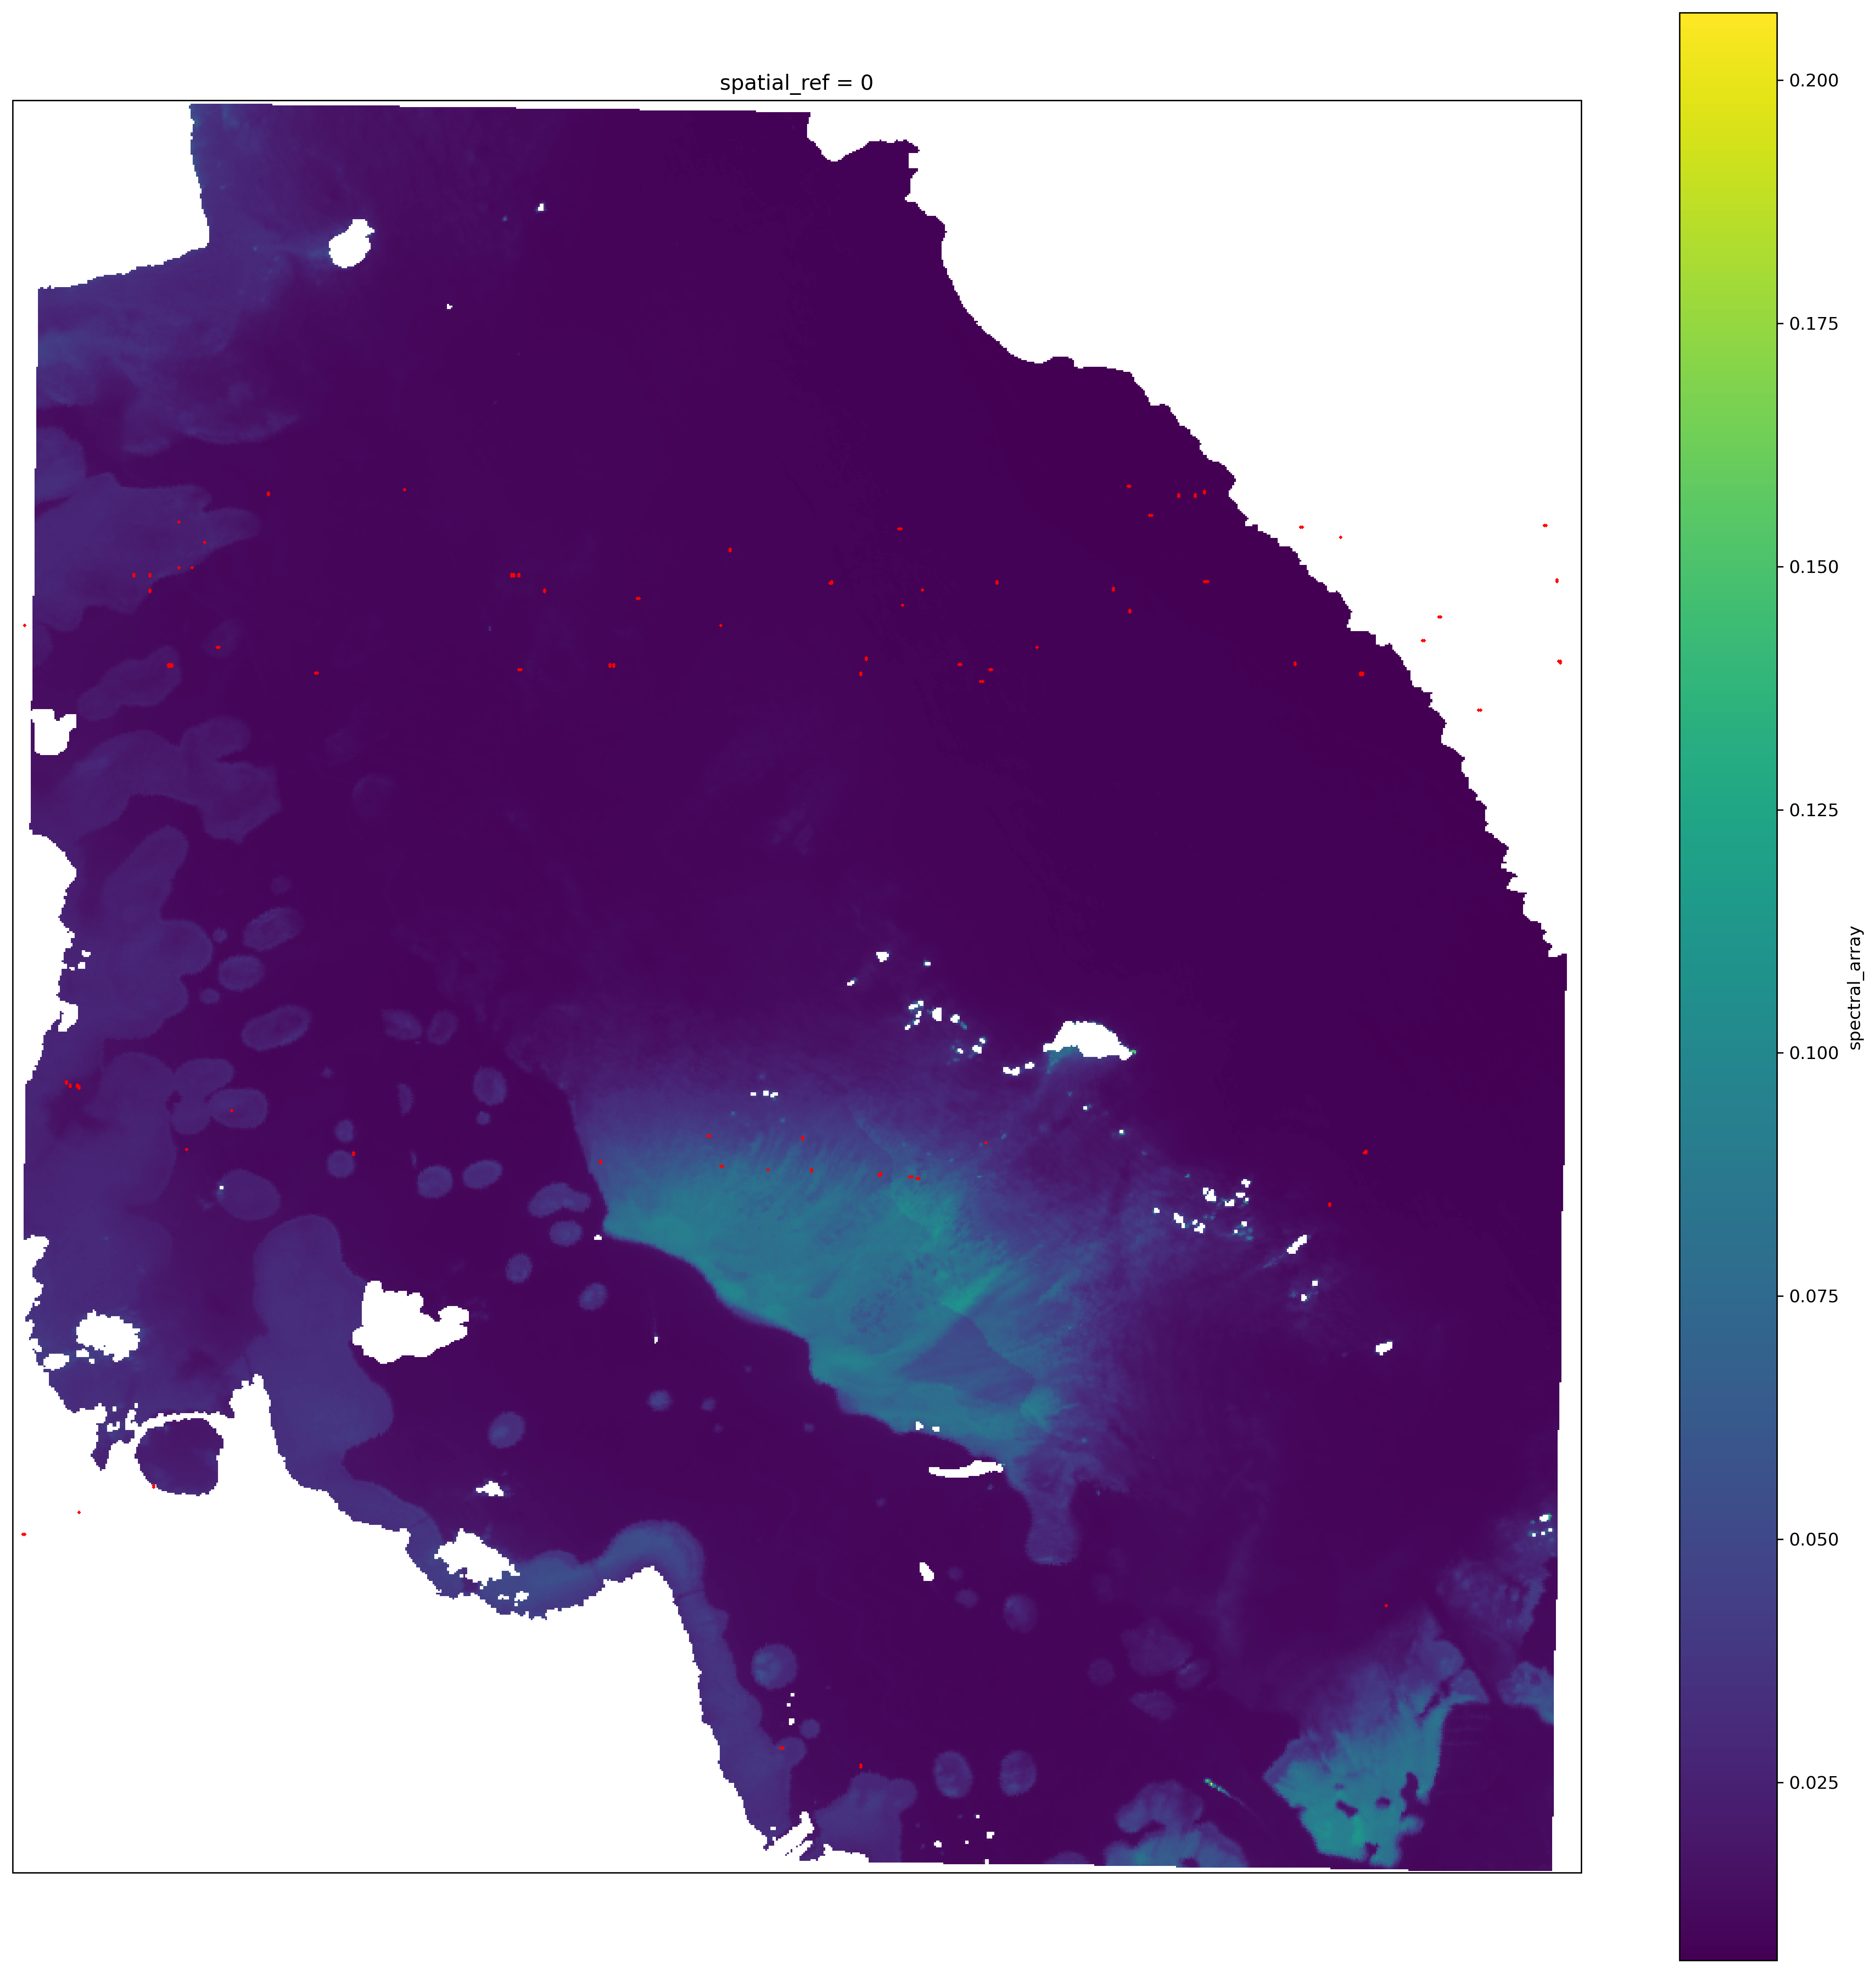

In [ ]:
import cartopy.crs as ccrs

fig, ax = plt.subplots(1,1, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(20, 20), dpi=300)
test_scene_site_xa.spectral_array.median(dim="band", skipna=True).plot(ax=ax, transform=ccrs.PlateCarree())

# plot non-nan site values as scatter points
site_x, site_y = np.where(~np.isnan(test_scene_site_xa.site.values))
# select latitude and longitude values by index (site_x, site_y)
latitudes = [lat[site_y[i], site_x[i]] for i in range(len(site_x))] 
longitudes = [lon[site_y[i], site_x[i]] for i in range(len(site_y))]

ax.scatter(longitudes, latitudes, c="r", s=1, marker="x", transform=ccrs.PlateCarree())